In [56]:
import pandas as pd
dat = pd.read_pickle('minutely_bull.pkl')
model_file_suffix = 'mbu_3'

window_size, episode_count = 3, 150
data_to_modify = dat.reset_index(level=0)

In [57]:
# agent.memory
import random
from collections import namedtuple

Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [58]:
# agent.model
import torch
import torch.nn as nn

class DQN(nn.Module):
	def __init__(self, state_size, action_size):
		super(DQN, self).__init__()
		self.main = nn.Sequential(
			nn.Linear(state_size, 64),
			nn.LeakyReLU(0.01, inplace=True),
			nn.Linear(64, 32),
			nn.LeakyReLU(0.01, inplace=True),
			nn.Linear(32, 16),
			nn.LeakyReLU(0.01, inplace=True),
			nn.Linear(16, 8),
			nn.LeakyReLU(0.01, inplace=True),
			nn.Linear(8, action_size),
		)
	
	def forward(self, input):
		return self.main(input)

In [59]:
# agent.agent
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import os

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_size = 3

class Agent:
	def __init__(self, state_size, is_eval=False):
		self.state_size = data_size * state_size # normalized previous days || 3: 3 values
		self.action_size = 3 # sit, buy, sell
		self.memory = ReplayMemory(10000)
		self.inventory = []
		self.is_eval = is_eval

		self.gamma = 0.9
		self.epsilon = 0.9
		self.epsilon_min = 0.01
		self.epsilon_decay = 0.99
		self.batch_size = 16
		if os.path.exists('models/B2/target_model_' + model_file_suffix):
			self.policy_net = torch.load('models/B2/policy_model_' + model_file_suffix, map_location=device)
			self.target_net = torch.load('models/B2/target_model_' + model_file_suffix, map_location=device)
		else:
			self.policy_net = DQN(data_size * state_size, self.action_size).to(device)
			self.target_net = DQN(data_size * state_size, self.action_size).to(device)
		self.optimizer = optim.RMSprop(self.policy_net.parameters(), lr=0.0005, momentum=0.8)

	def act(self, state):
		if not self.is_eval and np.random.rand() <= self.epsilon:
			return random.randrange(self.action_size)

		tensor = torch.FloatTensor(state).to(device)
		options = self.target_net(tensor)
		try:
			return np.argmax(options[0].detach().numpy())
		except:
			return np.argmax(options[0].detach().cpu().numpy())

	def optimize(self):
		if len(self.memory) < self.batch_size:
				return
		transitions = self.memory.sample(self.batch_size)
		# Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
		# detailed explanation). This converts batch-array of Transitions
		# to Transition of batch-arrays.
		batch = Transition(*zip(*transitions))

		# Compute a mask of non-final states and concatenate the batch elements
		# (a final state would've been the one after which simulation ended)
		# print('brw', batch.reward)
		next_state = torch.FloatTensor(batch.next_state).to(device)
		non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, next_state)))
		non_final_next_states = torch.cat([s for s in next_state if s is not None])
		state_batch = torch.FloatTensor(batch.state).to(device)
		action_batch = torch.LongTensor(batch.action).to(device)
		reward_batch = torch.FloatTensor(batch.reward).to(device)
		# print('next state', next_state.size())
		# print('non_final_mask', non_final_mask.size())
		# print('non_final_next_states', non_final_next_states.size())
		# print('state_batch', state_batch.size())
		# print('action_batch', action_batch.size())
		# print('reward_batch', reward_batch.size())

		# Compute Q(s_t, a) - the model computes Q(s_t), then we select the
		# columns of actions taken. These are the actions which would've been taken
		# for each batch state according to policy_net
		#state_action_values = self.policy_net(state_batch).reshape((self.batch_size, 3)).gather(1, action_batch.reshape((self.batch_size, 1)))
		state_action_values = self.policy_net(state_batch).reshape((self.batch_size, 3)).gather(1, action_batch.reshape((self.batch_size, 1)))

		# Compute V(s_{t+1}) for all next states.
		# Expected values of actions for non_final_next_states are computed based
		# on the "older" target_net; selecting their best reward with max(1)[0].
		# This is merged based on the mask, such that we'll have either the expected
		# state value or 0 in case the state was final.
		next_state_values = torch.zeros(self.batch_size, device=device)
		next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()
		# Compute the expected Q values
		expected_state_action_values = (next_state_values * self.gamma) + reward_batch

		# Compute Huber loss
		loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

		# Optimize the model
		self.optimizer.zero_grad()
		loss.backward()
		for param in self.policy_net.parameters():
				param.grad.data.clamp_(-1, 1)
		self.optimizer.step()

In [60]:
# functions
def flatten_list(_2d_list):
    flat_list = []
    # Iterate through the outer list
    for element in _2d_list:
        if type(element) is list:
            # If the element is of type list, iterate through the sublist
            for item in element:
                flat_list.append(item)
        else:
            flat_list.append(element)
    return flat_list

# prints formatted price
def formatPrice(n):
	return ("-$" if n < 0 else "$") + "{0:.2f}".format(abs(n))

# returns the vector containing stock data from a fixed file
def getStockDataVec(datax):
	vec = []
	for index, line in datax.iterrows():
		if data_size == 3:
			vec.append(np.array([line['close'], line['ewm'], line['macd_histo']])) #print(line['close'], line['ewm'], line['macd_histo'])else:
		else:
			vec.append(line['close']) #print(line['close'], line['ewm'], line['macd_histo'])
  # lines = datax.to_csv().splitlines()
	# for line in lines:
	# 	vec.append([line])
	return vec

	# for line in lines[1:]:
	# 	close = line.split(",")[4]
	# 	if close != 'null':
	# 		vec.append(float(line.split(",")[4]))
  # 

# returns the sigmoid
def sigmoid(x):
	return 1 / (1 + np.exp(-x))

#100-period sortino ratio
def roll_sortino(df): #t: last time ratio
  risk_free = 0 #0 percent
  returns = (df - df.shift(-1)).to_numpy()[:-1]
  return_negative_normal = returns[returns < 0]
  return_negative_std = return_negative_normal.std() if len(return_negative_normal) > 0 else 0
  sortino_roll = (returns.mean() - risk_free) / return_negative_std * np.sqrt(100) if return_negative_std > 0 else 0
  # print("srtdf", return_negative_normal, 'SSSTD', return_negative_std, 'SRLLL', sortino_roll)
  # print("SRRL", sortino_roll)
  return sortino_roll

def sortino(t): #time period: m for minute, h for hour, t: truncated
  df_truncated = data_to_modify.head(t)
  df_sortino = roll_sortino(df_truncated['dqn_return'].tail(100))
  # print("srt", df_truncated['sortino'], df_truncated['dqn_return'])
  if t == 0:
    data_to_modify.loc[t, 'sortino'] = 0
    sortino_ = 0
  else:
    data_to_modify.loc[t, 'sortino'] = df_sortino
    sortino_ = df_sortino
  # print(float(sortino_))
  return float(sortino_)

countx = 0
# returns an an n-day state representation ending at time t
###################### MAKE THIS [32, 1, 15] INSTEAD OF [32, 15]
def getState(data, t, n, cap_now):
  global countx
  d = t - n + 1
  block = data[d:t + 1] if d >= 0 else -d * [data[0]] + data[0:t + 1] # pad with t0
  res = []

  for i in range(n - 1):
    state_ = []
    if data_size == 1:
      state_ = sigmoid(block[i + 1] - block[i])
    else:
      state_.append(sigmoid((block[i + 1][0] - block[i][0]))) # price movement
      state_.append(sigmoid((block[i + 1][1] - block[i][1]))) # price w.r.t. ema28
      state_.append(sigmoid((block[i + 1][0] - cap_now))) # cap now vs price now
    res.append(state_)
      # print("BK", block)
      # print("-SIG", block[i + 1][k] - block[i][k])
      # print("ST", state_)
  if data_size == 1:
    return np.array(res).reshape(1, data_size * window_size)
  else:
    return np.array(flatten_list(res)).reshape(1, data_size * window_size)

In [61]:
# train
agent = Agent(window_size)
data = getStockDataVec(data_to_modify)
l = len(data) - 1

capital = 10000
capital_now = capital + 0
max_investment = capital + 0
mdd = 0
closes = []
buys = []
sells = []

results_ = []

for e in range(episode_count + 1):
	capital = 10000
	capital_now = capital + 0
	max_investment = capital + 0
	mdd = 0
	closes = []
	buys = []
	sells = []
	print("Episode " + str(e) + "/" + str(episode_count))
	state = getState(data, 0, window_size + 1, capital_now)
	stop = False

	agent.inventory = []

	for t in range(l):
		action = agent.act(state)
		# sit
		reward = 0

		# print(agent.inventory, data[t])
		if action == 1: # buy
			reward = 0
			if capital_now and len(agent.inventory) == 0:
				btc_price = data[t] if data_size == 1 else data[t][0]
				btc_bought = capital_now/btc_price
				agent.inventory.append((btc_bought, btc_price)) # price
				buys.append(data[t])
				data_to_modify.at[t, 'dqn_return'] = capital_now / capital
				data_to_modify.at[t, 'action'] = 'buy-buy'
				if t == 0:
					data_to_modify.at[t, 'mdd'] = 0
				else:
					data_to_modify.at[t, 'mdd'] = data_to_modify.at[t - 1, 'mdd']
				sortino_current = sortino(t)
				sells.append(None)
				# calculate sortino
				capital_now = 0
			else:
				if (len(agent.inventory) > 0):
					capital_now = agent.inventory[0][0] * data[t] if data_size == 1 else agent.inventory[0][0] * data[t][0]
					data_to_modify.at[t, 'action'] = 'buy-hold-full'
					data_to_modify.at[t, 'dqn_return'] = capital_now / capital
					if capital_now > max_investment:
						max_investment = capital_now
					if (max_investment - capital_now) / max_investment > mdd:
						mdd = (max_investment - capital_now) / max_investment
				else:
					data_to_modify.at[t, 'dqn_return'] = capital_now / capital
					data_to_modify.at[t, 'action'] = 'buy-hold-nocapital'
				data_to_modify.at[t, 'mdd'] = data_to_modify.at[t - 1, 'mdd']
				sortino_current = sortino(t)
				buys.append(None)
				sells.append(None)
			#if capital > data[t]:
				#agent.inventory.append(data[t])
				#buys.append(data[t])
				#sells.append(None)
				#capital -= data[t]
			#else:
				#buys.append(None)
				#sells.append(None)
        
		elif action == 2: # sell
			if len(agent.inventory) > 0:
				btc_bought, bought_price = agent.inventory.pop(0)
				capital_now = btc_bought * data[t] if data_size == 1 else btc_bought * data[t][0]
				data_to_modify.at[t, 'dqn_return'] = capital_now / capital
				data_to_modify.at[t, 'action'] = 'sell-sell'
				reward_1 = 100 * (capital_now - btc_bought * bought_price) / (btc_bought * bought_price) # reward 1: Return in %
				# print("BB", int(btc_bought * 10000), "BP", int(bought_price), "FROM", int(btc_bought * bought_price), "TO", int(capital_now), "RET", int(10*reward_1)/10, "AINV", agent.inventory)
				if capital_now > max_investment:
					max_investment = capital_now
				if (max_investment - capital_now) / max_investment > mdd:
					mdd = (max_investment - capital_now) / max_investment
				sortino_current = sortino(t)
				data_to_modify.at[t, 'mdd'] = mdd
				# calculate mdd??? sortino???
        # if mdd decreases = penalty, else reward
        # if sortino decreases = penalty, else reward
				reward_2 = data_to_modify.at[t - 1, 'mdd'] - mdd #mdd
				reward_3 = sortino_current / np.sqrt(100) #sortino
				reward = max(reward_1 + reward_2 + reward_3, 0) #reward = max(data[t] - bought_price, 0)
				data_to_modify.at[t, 'reward'] = "[{0:.2f}]{1:.2f}/{2:.2f}/{3:.2f}".format(reward, reward_1, reward_2, reward_3)
				# print(reward_1, reward_2, reward_3)
				buys.append(None)
				sells.append(data[t])
			else:
				reward = 0
				data_to_modify.at[t, 'dqn_return'] = capital_now / capital
				data_to_modify.at[t, 'action'] = 'sell-noasset'
				if t == 0:
					data_to_modify.at[t, 'mdd'] = 0
				else:
					data_to_modify.at[t, 'mdd'] = data_to_modify.at[t - 1, 'mdd']
				sortino_current = sortino(t)
				buys.append(None)
				sells.append(None)
        
		elif action == 0: # hodl
			reward = 0
			if capital_now > 0: # hodl idle
				data_to_modify.at[t, 'dqn_return'] = capital_now / capital
				data_to_modify.at[t, 'action'] = 'idle'
			else: # hodl hodl
				try:
					data_to_modify.at[t, 'dqn_return'] = (agent.inventory[0][0] * data[t]) / capital if data_size == 1 else (agent.inventory[0][0] * data[t][0]) / capital
				except:
					if t > 0:
						data_to_modify.at[t, 'dqn_return'] = data_to_modify.at[t - 1, 'dqn_return']
					else:
						data_to_modify.at[t, 'dqn_return'] = 1
				data_to_modify.at[t, 'action'] = 'hodl'
			if t == 0:
				data_to_modify.at[t, 'mdd'] = 0
			else:
				data_to_modify.at[t, 'mdd'] = data_to_modify.at[t - 1, 'mdd']
			sortino_current = sortino(t)
			buys.append(None)
			sells.append(None)

		if reward == 0:
			data_to_modify.at[t, 'reward'] = "0"
		done = True if t == l - 1 else False
		# print(int(reward * 10), end=' ')
		if data_size == 1:
			capital_next = agent.inventory[0][0] * data[t] if len(agent.inventory) else capital_now
		else:
			capital_next = agent.inventory[0][0] * data[t][0] if len(agent.inventory) else capital_now
		next_state = getState(data, t + 1, window_size + 1, capital_next)
		agent.memory.push(state, action, next_state, reward)
		state = next_state

		if done:
			print("--------------------------------")
			if data_size == 1:
				capital_final = agent.inventory[0][0] * data[t] if len(agent.inventory) else capital_now
			else:
				capital_final = agent.inventory[0][0] * data[t][0] if len(agent.inventory) else capital_now
			results_.append(capital_final / capital)
			print("Total Return: " + str((capital_final - capital) / capital))
			print("--------------------------------")
			# x = input()
			# if x == 'y':
			# 	stop = True
		agent.optimize()
	if stop:
		break

	if e % 10 == 0:
		agent.target_net.load_state_dict(agent.policy_net.state_dict())
		torch.save(agent.policy_net, "models/B2/policy_model" + model_file_suffix)
		torch.save(agent.target_net, "models/B2/target_model" + model_file_suffix)

Episode 0/0
--------------------------------
Total Return: 0.016521477119305565
--------------------------------


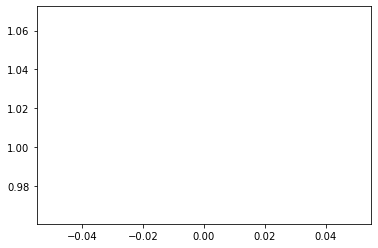

1.0165214771193056


In [62]:
import matplotlib.pyplot as plt
def moving_average(a, n=3) :
    pad = np.array([capital for i in range(n - 1)])
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

xpoints = np.array([s for s in range(len(results_))])
ypoints = np.array([s for s in results_])
ypoints_ma = moving_average(ypoints, 15)

plt.plot(xpoints, ypoints)
plt.plot(xpoints[14:], ypoints_ma)
plt.show()

print(ypoints.mean())


In [63]:
import pickle
pickle.dump({'name': 'minute_model_bear', 'ypoints' :ypoints, 'yma': ypoints_ma, 'traddata': data_to_modify}, open("models/B2/minutebear_3.pkl", 'ab'))
data_to_modify

,time,high,low,open,close,ewm,macd_histo,return,dqn_return,action,mdd,sortino,reward
0,2023-02-14 04:40:00,21744.54,21740.71,21744.42,21740.88,21740.880000,0.000000,NaN,1.000000,sell-noasset,0.000000,0.000000,0
1,2023-02-14 04:41:00,21744.88,21740.58,21740.88,21744.09,21741.101379,0.204855,0.000148,1.000000,sell-noasset,0.000000,0.000000,0
2,2023-02-14 04:42:00,21744.64,21743.74,21744.09,21744.55,21741.339215,0.351404,0.000021,1.000000,buy-buy,0.000000,0.000000,0
3,2023-02-14 04:43:00,21744.55,21740.33,21744.55,21740.52,21741.282718,0.166384,-0.000185,0.999815,hodl,0.000000,0.000000,0
4,2023-02-14 04:44:00,21740.52,21733.91,21740.52,21734.18,21740.792875,-0.364556,-0.000292,0.999523,sell-sell,0.000477,0.000000,[-0.05]-0.05/-0.00/0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,2023-02-15 13:56:00,22734.46,22722.95,22732.99,22723.87,22734.866055,-0.406212,-0.000401,1.017548,buy-buy,0.015976,0.165158,0
1997,2023-02-15 13:57:00,22723.87,22712.32,22723.87,22712.90,22733.351155,-2.116000,-0.000483,1.017057,buy-hold-full,0.015976,0.150024,0
1998,2023-02-15 13:58:00,22713.26,22703.47,22712.90,22704.37,22731.352455,-3.648014,-0.000376,1.016675,buy-hold-full,0.015976,0.179371,0
1999,2023-02-15 13:59:00,22704.37,22698.08,22704.37,22700.95,22729.255734,-4.653869,-0.000151,1.016521,buy-hold-full,0.015976,0.207814,0
